In [1]:
import os
import subprocess

import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
import time

In [2]:
def load_example(df_row):
    image = torchvision.io.read_image(df_row['image_path'])
    
    result = {
        'image': image,
        'class': df_row['Class']
    }
    return result

In [3]:
class HiddenDataset(Dataset):
    def __init__(self, split='train'):
        super().__init__()
        self.examples = []
        if split == 'val':
            df = pd.read_csv(f'FashionMNIST/{split}_mini.csv')
        else:
            df = pd.read_csv(f'FashionMNIST/{split}_mini.csv')
        df['image_path'] = df['Image_File'].apply(
            lambda x: os.path.join('FashionMNIST/train/', x))
        df = df.sort_values(by='image_path')
        df.apply(lambda row: self.examples.append(load_example(row)), axis=1)
        if len(self.examples) == 0:
            raise ValueError('No examples.')

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        image = example['image']
        image = image.to(torch.float32)
        example['image'] = image
        return example

In [4]:
def get_dataset(batch_size , aug = True):
    train_ds = HiddenDataset(split='train')
    retain_ds = HiddenDataset(split='retain')
    forget_ds = HiddenDataset(split='forget')

    retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True)
    forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    return retain_loader, forget_loader, train_loader

In [5]:
retain_loader, forget_loader, train_loader = get_dataset(1 , True)

In [14]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [89]:
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(torch.load('learned_resnet.pth'))

<All keys matched successfully>

In [90]:
unlearned_model = resnet18(weights=None, num_classes=10)
unlearned_model.load_state_dict(torch.load('unlearned_resnet.pth'))

<All keys matched successfully>

In [91]:
target_layers = [model.layer4[-1]]
target_layers_unlearned = [unlearned_model.layer4[-1]]

In [92]:
input_tensor = forget_loader.dataset[0]['image']

rgb_image = input_tensor.permute(1, 2, 0).numpy()

input_tensor = torch.cat((input_tensor, input_tensor, input_tensor), 0)
input_tensor = input_tensor.unsqueeze(0)

In [93]:
# Bring rgb image values between 0 and 1

rgb_image = rgb_image / 255.0

In [94]:
cam = GradCAM(model=model, target_layers=target_layers)
cam_unlearned = GradCAM(model=unlearned_model, target_layers=target_layers_unlearned)

In [95]:
grayscale_cam = cam(input_tensor=input_tensor, targets=None)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

In [96]:
grayscale_cam_unlearned = cam_unlearned(input_tensor=input_tensor, targets=None)
grayscale_cam_unlearned = grayscale_cam_unlearned[0, :]
visualization_unlearned = show_cam_on_image(rgb_image, grayscale_cam_unlearned, use_rgb=True)

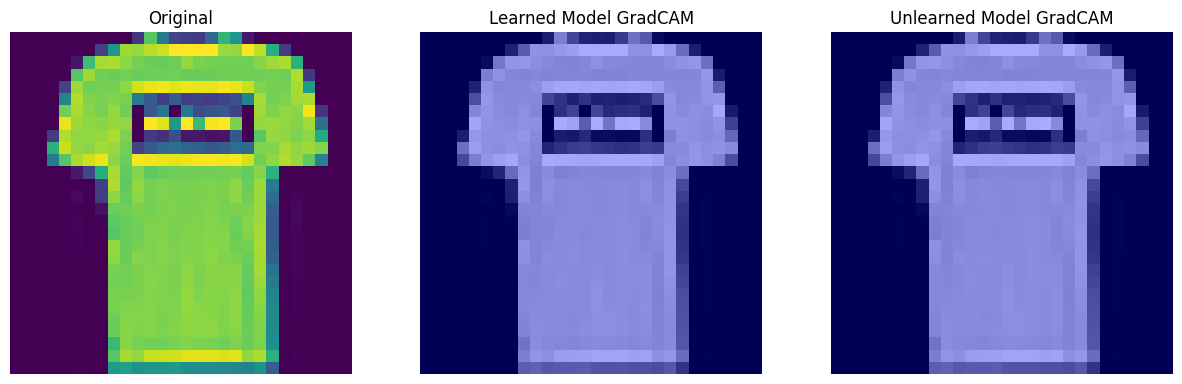

In [97]:
# Display visualization with matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(rgb_image)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Learned Model GradCAM')
plt.imshow(visualization)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Unlearned Model GradCAM')
plt.imshow(visualization_unlearned)
plt.axis('off')
plt.show()